In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import os
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

In [3]:
plt.style.use('seaborn')

In [4]:

# Import dataset and useful labels

with open('./useful_labels.pkl','rb') as f:
    boundingBox = pickle.load(f)
    
df = pd.read_csv('./Dataset.csv')
df.head()

,file_name,xmin,ymin,xmax,ymax,label
0,hard_hat_workers2536,"[239, 102, 102]","[114, 67, 0]","[262, 148, 149]","[149, 121, 38]","['helmet', 'helmet', 'helmet']"
1,hard_hat_workers721,"[203, 223, 231, 251, 285, 304, 380, 370, 344]","[190, 196, 205, 184, 183, 164, 183, 210, 194]","[217, 237, 245, 265, 299, 324, 396, 382, 358]","[209, 214, 219, 204, 202, 188, 202, 225, 213]","['helmet', 'helmet', 'helmet', 'helmet', 'helm..."
2,hard_hat_workers3425,"[135, 226, 181, 134, 181]","[116, 172, 131, 0, 0]","[162, 251, 207, 162, 208]","[148, 204, 156, 23, 8]","['helmet', 'helmet', 'helmet', 'helmet', 'helm..."
3,hard_hat_workers3947,"[113, 142, 184, 223, 269, 306, 335, 134]","[148, 138, 158, 134, 161, 165, 157, 143]","[132, 166, 216, 267, 309, 325, 394, 145]","[174, 176, 198, 187, 210, 192, 226, 173]","['helmet', 'helmet', 'helmet', 'helmet', 'helm..."
4,hard_hat_workers1934,"[204, 334]","[70, 69]","[332, 414]","[211, 211]","['helmet', 'helmet']"


In [5]:
boundingBox['hard_hat_workers0.png']

{'dimension': [[357, 116, 404, 175],
  [4, 146, 39, 184],
  [253, 139, 275, 177],
  [300, 145, 323, 181],
  [116, 151, 138, 180],
  [80, 151, 100, 180],
  [62, 144, 83, 172],
  [322, 141, 345, 178],
  [175, 156, 194, 186],
  [222, 151, 240, 182],
  [200, 146, 216, 173],
  [98, 140, 112, 160],
  [157, 150, 175, 177]],
 'label': ['helmet',
  'helmet',
  'helmet',
  'helmet',
  'helmet',
  'helmet',
  'head',
  'head',
  'head',
  'head',
  'head',
  'helmet',
  'head']}

### Plot Some images

In [6]:
# Plot Single Image

path = '../Dataset - Safety Helment/'

def plotIamge(image):
    fig,ax = plt.subplots(figsize=(8,8))
    img = plt.imread(os.path.join(path,'images',image))
    ax.imshow(img)
    B = boundingBox[image]
    for bbx,label in zip(B['dimension'],B['label']):
        bbx[2] = abs(bbx[0]-bbx[2])
        bbx[3] = abs(bbx[1]-bbx[3])
        ax.add_patch(Rectangle((bbx[0],bbx[1]),bbx[2],bbx[3],fc ='none',ec ='black',lw = 2))
        ax.text(bbx[0]+5,bbx[1],label,bbox=dict(facecolor='red', alpha=0.5))
        ax.set_title(image,fontsize=15)
        
    plt.axis('off')
    plt.show()

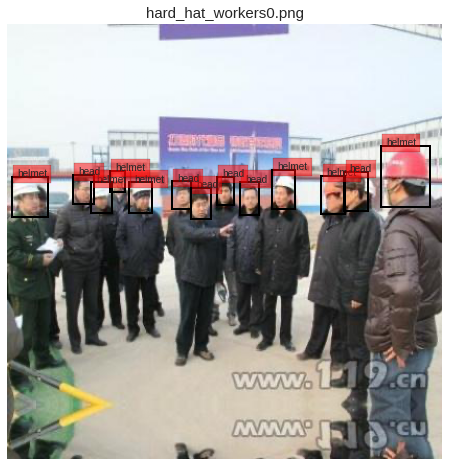

In [7]:
plotIamge('hard_hat_workers0.png')

In [8]:
# Plot Multple Images

from object_detection_fastai.helper.object_detection_helper import *

In [9]:
def get_bbox(image):
    
    labels = []
    
    image = image.split('/')[-1]
    label = boundingBox[image]
    bboxs = label['dimension']
    for i in range(len(bboxs)):
        bbox = bboxs[i]
        bboxs[i] = [bbox[1],bbox[0],bbox[3],bbox[2]]
    
    labels.append(bboxs)
    labels.append(label['label'])
    return labels

size = 512

# Prepare DataBunch
images = (ObjectItemList.from_df(df, path, cols='file_name', folder='images',suffix='.png')
          .split_by_rand_pct(0.2)
          .label_from_func(get_bbox)
          .transform(size=size,tfm_y=True)
          .databunch(bs=8, collate_fn=bb_pad_collate))

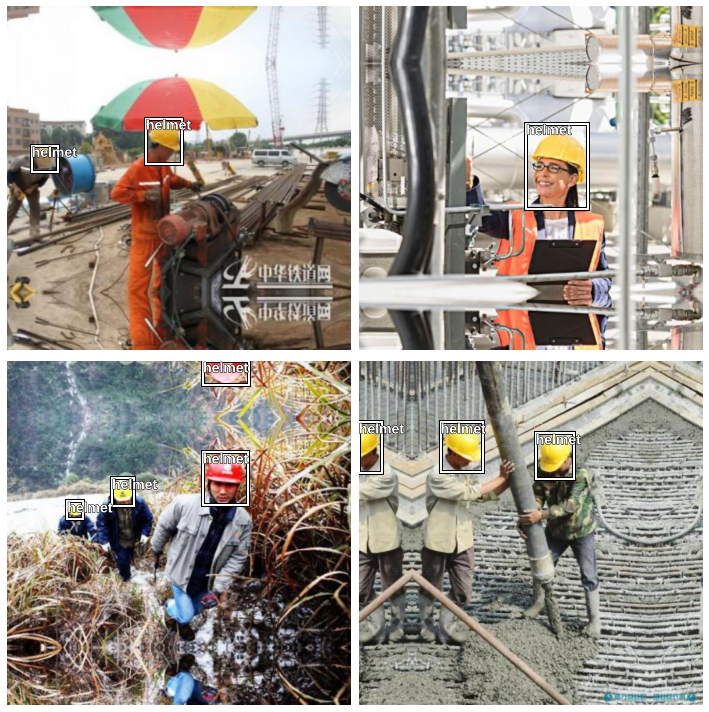

In [10]:
images.show_batch(rows=2,  figsize=(10,10))

In [11]:
len(images.train_ds),len(images.valid_ds),images.classes

(4000, 1000, ['background', 'head', 'helmet'])

### Prepare Images For Training

In [12]:
from fastai.vision import *
from fastai import *
from fastai.callbacks import *
from sklearn.model_selection import StratifiedKFold,KFold

from object_detection_fastai.loss.RetinaNetFocalLoss import RetinaNetFocalLoss
from object_detection_fastai.models.RetinaNet import RetinaNet
from object_detection_fastai.callbacks.callbacks import BBLossMetrics, BBMetrics, PascalVOCMetric

In [13]:
anchors = create_anchors(sizes=[(32,32)], ratios=[1], scales=[0.3, 0.6, 1.2, 2, 2.8, 3.4,])

In [14]:
n_classes = images.train_ds.c

crit = RetinaNetFocalLoss(anchors)

encoder = create_body(models.resnet18, True, -2)
model = RetinaNet(encoder, n_classes=images.train_ds.c, n_anchors=6, sizes=[32], chs=32, final_bias=-4., n_conv=3)

In [15]:
import os

try:
    try:
        os.mkdir('models')
    except:
        os.mkdir('models/weights')
except:
    print('dir exist')

dir exist


In [16]:
voc = PascalVOCMetric(anchors, size, [i for i in images.train_ds.y.classes[1:]])
learn = Learner(images, model, 
                loss_func=crit, 
                callback_fns=[BBMetrics],
                metrics=[voc],
               model_dir='/models/',)

In [17]:
learn.split([model.encoder[6], model.c5top5])
learn.freeze_to(-2)

gc.collect()

8387

In [ ]:
learn.fit_one_cycle(3, 1e-3, callbacks = [SaveModelCallback(learn, 
                                                            every ='improvement', 
                                                            monitor = 'AP-helmet', 
                                                            name = 'best_model')])

epoch,train_loss,valid_loss,pascal_voc_metric,BBloss,focal_loss,AP-head,AP-helmet,time
0,0.728178,0.810752,0.475545,0.243504,0.567247,0.388908,0.562182,02:23
1,0.429382,0.419279,0.621952,0.160686,0.258593,0.562435,0.681470,02:19
2,0.265426,0.346094,0.673905,0.135548,0.210545,0.638509,0.709301,02:19


Better model found at epoch 0 with AP-helmet value: 0.562182125486247.
Better model found at epoch 1 with AP-helmet value: 0.6814695126779542.
Better model found at epoch 2 with AP-helmet value: 0.7093011571803172.


In [ ]:
learn.load('best_model');
learn.export('/models/weights/safetyHelmet.pkl');

epoch,train_loss,valid_loss,pascal_voc_metric,BBloss,focal_loss,AP-head,AP-helmet,time
0,0.592108,0.658388,0.560511,0.198610,0.459778,0.529597,0.591425,02:20
1,0.564814,0.509337,0.567738,0.171913,0.337425,0.492685,0.642790,02:20
2,0.412110,0.480139,0.503697,0.161078,0.319061,0.377422,0.629973,02:22
3,0.271981,0.365882,0.669626,0.136669,0.229213,0.632207,0.707044,02:25
4,0.156641,0.337426,0.683276,0.124957,0.212469,0.665150,0.701402,02:24


Better model found at epoch 0 with AP-helmet value: 0.591424949709654.
Better model found at epoch 1 with AP-helmet value: 0.6427903535092147.
Better model found at epoch 3 with AP-helmet value: 0.7070443124689215.


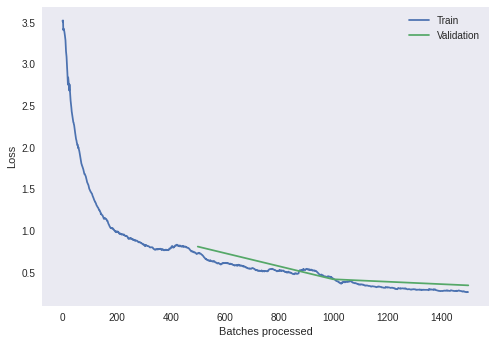

In [ ]:
learn.recorder.plot_losses()

learn.unfreeze()
learn.fit_one_cycle(5, 1e-3, callbacks = [SaveModelCallback(learn, every ='improvement', monitor ='AP-helmet', name ='best_model_ft')] )

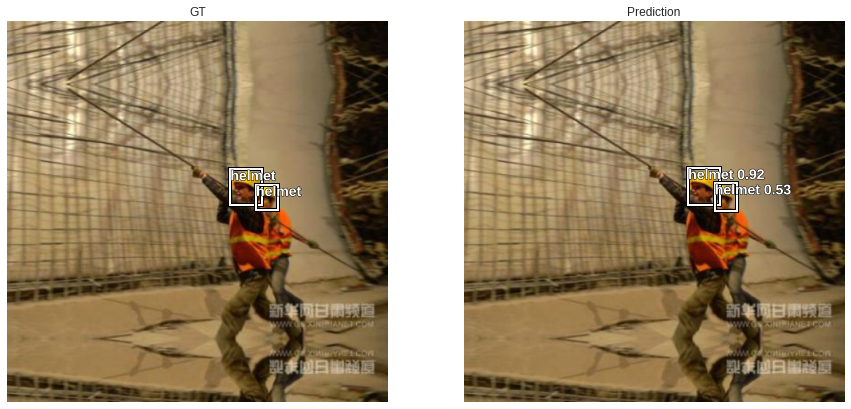

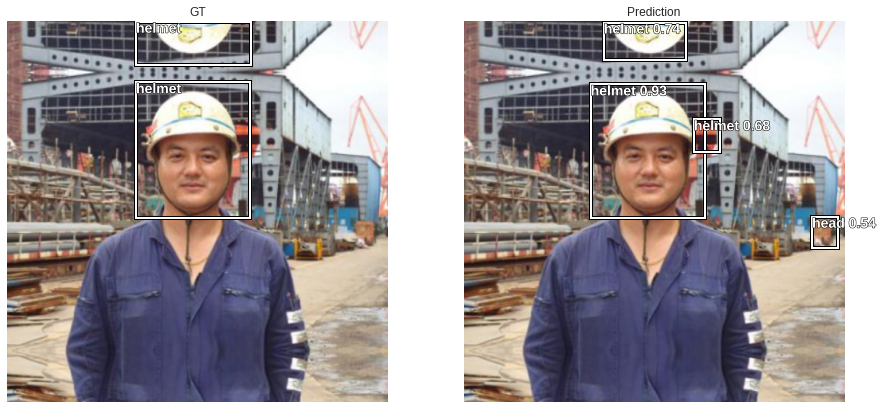

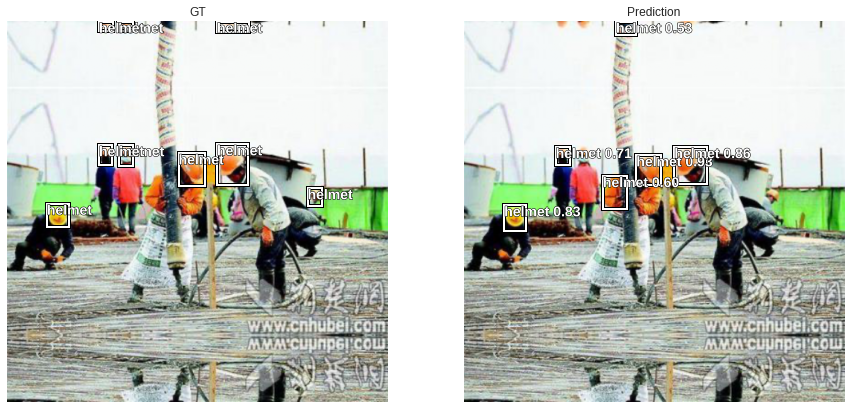

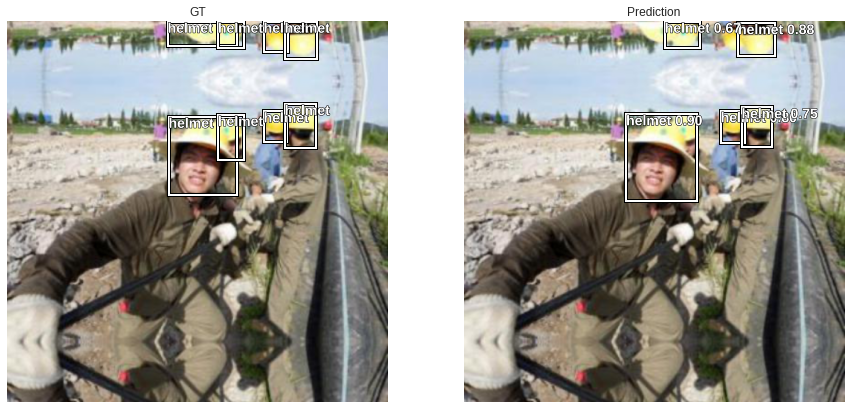

In [ ]:
show_results_side_by_side(learn, anchors, detect_thresh=0.5, nms_thresh=0.1, image_count=4)